## Theory
(taken from the fenics book)

We are solving the Helmholtz equation:
                       

 $$\nabla \times \frac{1}{\mu_r}\nabla \times \boldsymbol{E} - k_0^2 \epsilon_r \boldsymbol{E}=0,$$ with the boundary condition of electric mirrors.
 $$k_0 = \frac{2\pi f_0}{c_0}$$
 
 $$\epsilon_r = (n+\mathrm{i}k)^2$$

The functional is:
$$F(\boldsymbol{E}) = \frac{1}{2} \int_\Omega \left[\frac{1}{\mu_r} \left(\nabla \times \boldsymbol{E}\right)\cdot \left(\nabla \times \boldsymbol{E}\right) - k^2_0 \epsilon_r \boldsymbol{E}\boldsymbol{E}\right]dx$$

In order to find it the vector is split in to the transverse and axial components.

$$\nabla = \nabla_t + \nabla_z,$$
with $$\nabla_t = \hat{e_x}\frac{\partial}{\partial x} + \hat{e_y}\frac{\partial}{\partial y}$$
and $$\nabla_z = \hat{e_z}\frac{\partial}{\partial z}$$
We also assume that the electric field can be split like:
$$\boldsymbol{E}(x,y,z) = \left[E_t(x,y) + \hat{e_z} E_z(x,y) \right] e^{-\beta z}$$
where $\beta$ is the complex propagation constant,
$$\boldsymbol{E}_t = \hat{e_x} E_x + \hat{e_y} E_y$$ and $$ \boldsymbol{E}_{axial} = \hat{e_z} E_z$$

By splitting the $\nabla$ and by substituting the above for the electric field the functional becomes:
                               $$ F_{\beta}(\boldsymbol{E}) =  \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) \cdot \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) -k^2_0 \epsilon_r E_{t,\beta}E_{t,\beta} \\ + \beta^2 \left[\frac{1}{\mu_r} \left(\nabla_t E_z+\beta E_{t,\gamma}\right)\left(\nabla_t E_z+\beta E_{t,\gamma}\right) - k^2_0 \epsilon_r E_z E_z dx \right]$$

Since the functional is built now the electric field components need to be discetized in order to be calculated. 
The axial component can be discretised by nodal basis functions (Lagrandge) but the transverse need to be by two dimensional curl-conforming vector basis functions(Nedelec).

The electric field in the nedelec space is described by:
$$E_{t} = \sum_{i=1}^{N_{N}} (e_t)_i N_i$$

and the axial in lagrange elements as:

$$E_z = \sum_{i=1}^{N_{L}} (e_z)_i L_i$$
 Where $N_N$ and $N_L$ are the number of nedelec and lagrange elements respectively. $N_i$, $L_i$ are the basis functions and $e_t$, $e_z$ are the equivalent coefficients.

While the cuttoff method is easier to implement it only prety much finds the cuttoff wavenumber (shown in fenics book and in other papers). This is not what is of interest. I am interested in calculating the propagation constants $\beta$ and by extension the effective indices and the Electric field that they equate to.

The matrix eqution to be solved is

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Where $$A_{tt} = S_{tt} - k^2_0 T_{tt} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times N_i \right) \left(\nabla_t \times N_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r N_i N_jdx$$

$$B_{zz} = S_{zz} - k^2_0 T_{zz} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t L_i \right) \left(\nabla_t L_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r L_i L_j dx$$

$$ B_{tt} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  N_j dx$$

$$ B_{tz} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  \nabla_t L_j dx$$

$$ B_{zt} = \int_{\Omega} \frac{1}{\mu_r} \nabla_t L_i \cdot  N_j dx$$

### Code
Import the required modules

In [1]:
%matplotlib inline
from __future__ import division#, print_function
import numpy as np
from scipy.constants import c,pi
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from scipy.sparse import csr_matrix, lil_matrix, csc_matrix
import matplotlib.pylab as plt
from scipy.integrate import simps
import os
from matplotlib.colors import from_levels_and_colors
from dolfin import *
import time
from functions_dispersion_analysis import *

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The box domain:

In [2]:
a = 2e-4
b = 2e-4

Inputs of the problem

In [3]:
mu_r = 1.0 
lamda = 1.55e-6
r_core = 1e-5 # radius of core
r_clad = 10e-5 #radius of the fibre
nclad = 1.444#- 0.1e-4j# ref index of cladding
ncore = 1.445 - 1e-4j # ref index of core
#neff_g = 1.4445 # Guess of the modes
num= 10   #The number of modes guess 
neff_g= ncore
mesh_refinement = 0 # number of times to uniformly refine the mesh (used for convergence plots and better results)

In [5]:
from testing.Single_mode_fibre.Single_mode_theoretical import *
neff_th, Aeff_th = main_test(ncore,nclad,lamda,r_core,r_clad)

(2.18153612913-0.108843319296j)
Doing calculation for:  (1.445-0.0001j) 1.444 1.55e-06 1e-05


In [8]:
k = is_loss(ncore,nclad)
if k ==0:
    V = 2*pi/lamda*r_core*(ncore**2 - nclad**2)**0.5
    print(V)
k0 = 2*pi/lamda

In [5]:
def ref(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = ncore.real**2 - ncore.imag**2
    elif point > r_core and point <= r_clad:
        values[0] = nclad.real**2 - nclad.imag**2
    else:
        values[0] = 1.
    return values

def extinction(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = 2*ncore.imag*ncore.real
    elif point > r_core and point <= r_clad:
        values[0] = 2*nclad.imag*ncore.real
    else:
        values[0] = 0
    return values

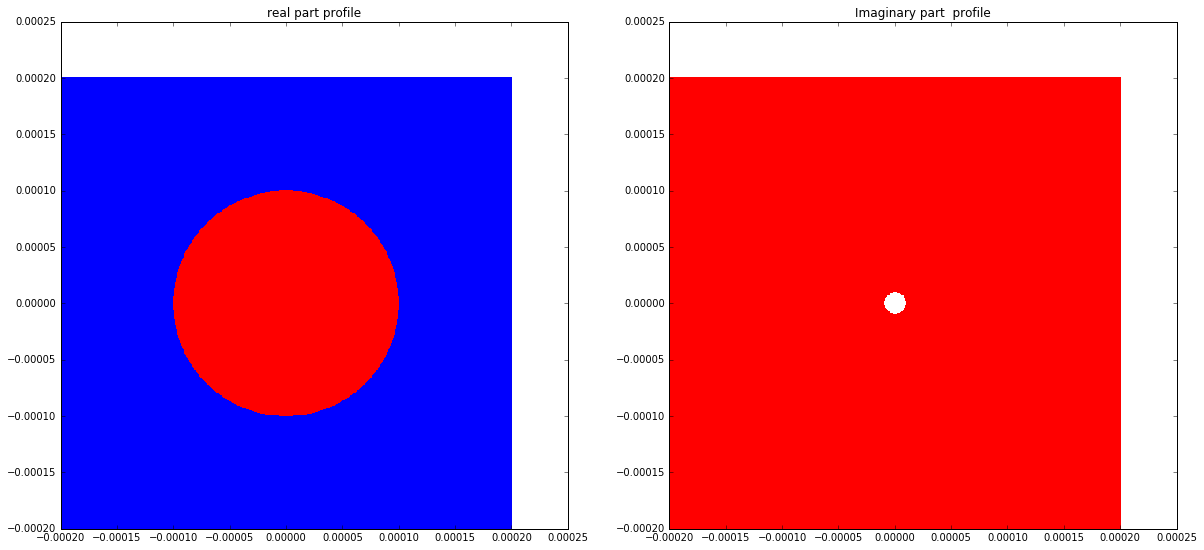

In [6]:
x = np.linspace(-a,a,512)
y = np.linspace(-b,b,512)
n_prof,k_prof = goemetry_plot(x,y,a,b,ref,extinction,nclad,ncore,r_core,r_clad)


In [7]:
class epsilon_real(Expression):
    def eval(self, values, x):
       values = ref(x,values)

class epsilon_imag(Expression):
    def eval(self, values, x):
       values = extinction(x,values)

## Mesh

Load the gmsh file and if asked for refine the mesh.

In [8]:
mesh = gmesh_mesh("original_geometry.geo",a,b,r_core,r_clad,mesh_refinement)
#plot(mesh,interactive=True)

Info    : Running 'gmsh fenics_mesh/Output.geo -2 -o fenics_mesh/output_small.msh' [Gmsh 2.10.1, 1 node, max. 1 thread]
Info    : Started on Tue May 31 10:47:42 2016
Info    : Reading 'fenics_mesh/Output.geo'...
Info    : Done reading 'fenics_mesh/Output.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 9 (Plane, Delaunay)
Info    : Meshing surface 11 (Plane, Delaunay)
Info    : Meshing surface 12 (Plane, Delaunay)
Info    : Done meshing 2D (0.00413895 s)
Info    : 106 vertices 241 elements
Info    : Writing 'fenics_mesh/output_small.msh'...
Info    : Done writing 'fenics_mesh/output_small.msh'
Info    : Stopped on Tue May 31 10:47:42 2016

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 105 vertices
Fo

In [9]:
#plot(mesh, interactive=True)

In [10]:
mesh.num_cells()

204

### Define the orders of the fucntion spaces for vector and nodal basis functions

In [11]:
num_cells = mesh.num_cells()

In [12]:
vector_order = 2
nodal_order = 3

Define the test and trial functions from the combined space here N_i and N_j are Nedelec basis functions and L_i and L_j are Lagrange basis functions

## Creating the matrix equation.

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Define the forms (matrix elements) for dispersion analysis into the basis functions

In [13]:
combined_space, A,B, A_complex,B_complex = Matrix_creation(mesh,epsilon_real,epsilon_imag,mu_r,k,k0,vector_order,nodal_order)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


post-multiplication by dx will result in integration over the domain of the mesh at assembly time

## Implement boundary conditions

In [14]:
A,B,A_complex,B_complex,electric_wall = Mirror_boundary(mesh,combined_space,A,B,A_complex,B_complex,k)
#free_dofs = boundary_marker_locator(A,electric_wall)
free_dofs = boundary_marker_locator(A,electric_wall)

### Free the vectors and make numpy arrays to solve with scipy

Find what part of the vectors are not ascociated with the boundary values

### Solve the eigenvalue system using scipy.linalg.eig

In [15]:
eigen,ev = find_eigenvalues(A,B,A_complex,B_complex,neff_g,num,k0,free_dofs,k,sparse_=True)

sparse eigenvalue time


Find $\beta$ from the eigenvalue.

In [16]:
beta =1j*(eigen)**0.5 
beta = np.abs(np.real(beta)) -1j*np.imag(beta)

sort the calculated values

In [17]:
sort_index = np.argsort(beta.real)[::-1]

In [18]:
propagating_modes = np.where(((beta[sort_index]/k0).real>nclad.real) & ((beta[sort_index]/k0).real<ncore))
propagating_modes = propagating_modes[0][:]

Print the first four effective indices. ((1.44446963419-7.85620938656e-05j))

In [19]:
print("The effective index of the most dominant modes are:")
print(beta[sort_index][propagating_modes]/k0)


The effective index of the most dominant modes are:
[ 1.44448345 -7.88233073e-05j  1.44448150 -7.85874601e-05j]


The effective index of the most dominant modes are:
[ 1.44448455+0.j  1.44448260+0.j  1.44429812+0.j]

num_cells = 204


(1.4444751261324063+0j) , (1.4444745265975403+0j)

816

3264

1.44446756+0.j  1.44446633+0.j

1.44447035+0.j  1.44447023+0.j

13056

Comsol : 1.4444696250032485-7.856091874511805E-5i

In [20]:
0,0,1
N_complex = []

In [21]:
from scipy.io import loadmat
refine=3

D = loadmat('convergence'+str(refine)+'.mat')

In [22]:
D

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon May 30 12:32:26 2016',
 '__version__': '1.0',
 'cells': array([[896]]),
 'neff': array([[ 1.44495351 -1.88996318e-14j,  1.44491525 -1.33123029e-15j,
          1.44482277 -2.46686819e-15j,  1.44479659 -5.13354884e-15j,
          1.44476882 -1.83536224e-15j,  1.44457684 -1.49266665e-15j,
          1.44456929 -2.79595199e-13j,  1.44456667 -8.16086037e-15j]])}

In [23]:
lim = D['neff'][0][2]
print(lim)
print(N_complex)

(1.44482277245-2.46686819304e-15j)
[]


In [24]:
N_complex.append(lim)
#for refine in range(4):
    

from scipy.io import savemat

np.abs(np.abs(np.imag(N_complex)) - np.abs(np.ones(len(N_complex)))*7.856091874511805e-5)

plotx, ploty = np.log(cells),1e6*np.abs(np.real(N_complex) - np.ones(len(N_complex))*1.4444696250032485) 
fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(plotx,ploty, '-o')
plt.xlabel(r'$\log\left(Nc\right)$')
plt.ylabel(r'$10^{6} \cdot \delta n_{eff}$')
plt.savefig(filename='conversion_complex_real.eps',bbox_inches='tight')


plotx, ploty = np.log(cells),1e7*np.abs(np.abs(np.imag(N_complex)) - np.abs(np.ones(len(N_complex)))*7.856091874511805e-5)
fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(plotx,ploty, '-o')
plt.xlabel(r'$\log\left(Nc\right)$')
plt.ylabel(r'$10^{7} \cdot \delta n_{eff}$')
plt.savefig(filename='conversion_complex_real.eps',bbox_inches='tight')


D = {}
D['cells'] = cells
D['N_complex'] =  N_complex

savemat('neff_complex.mat',D)

In [25]:
cells = [204,816,3264,13056]

In [26]:
neff_1 = [1.4444845, 1.4444751261324063, 1.44446756, 1.44447035]

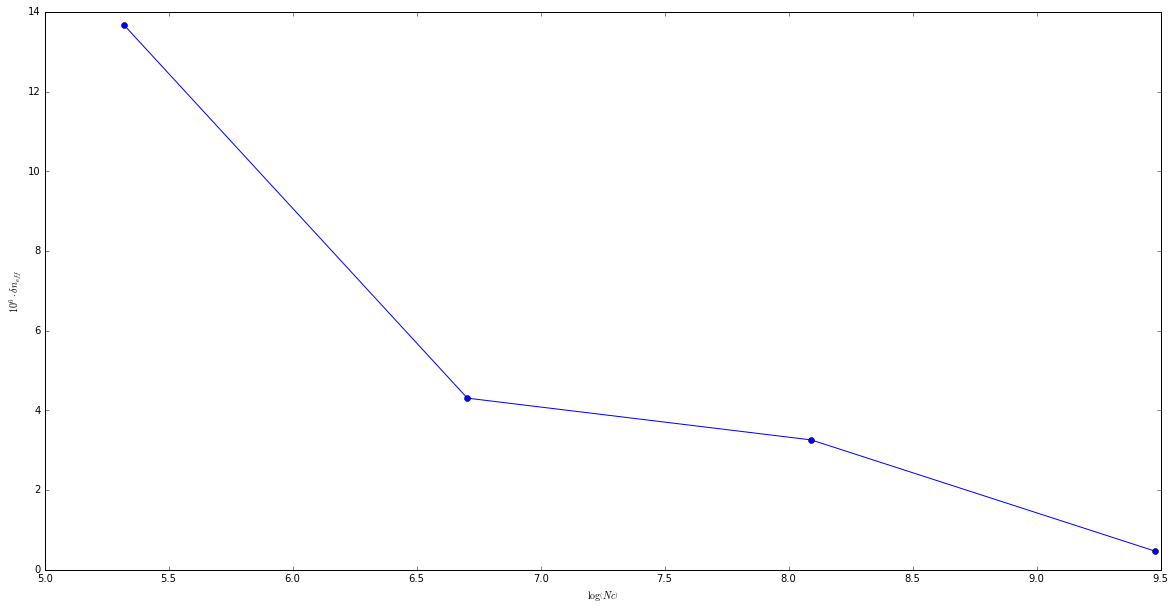

In [27]:
fig = plt.figure(figsize=(20.0, 10.0))
plt.plot(np.log(cells),1e6*(np.abs(neff_1 - np.ones(len(neff_1))*1.4444708192371853)), '-o')
plt.xlabel(r'$\log\left(Nc\right)$')
plt.ylabel(r'$10^{6} \cdot \delta n_{eff}$')
plt.savefig(filename='conversion.eps',bbox_inches='tight')

Use the eigenvalues/eigenvectors to release the electric field

### Plot the results

In [28]:
size1,size2 = 512,512
min_max = (-3*r_core,3*r_core,-3*r_core,3*r_core)

In [29]:
mode0 = modes(1,size1,size2,min_max,propagating_modes,beta,sort_index,k0)
mode0.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


In [42]:
print(mode0.E.shape)

(512, 512, 2)


In [32]:
mode0.effective_area(k,A,ev,sort_index,free_dofs,combined_space,r_clad)

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [6]:
mode0.Aeff

NameError: name 'mode0' is not defined

In [31]:
mode0.effective_area_simps(k,A,ev,sort_index,free_dofs,combined_space)

(4.4607878253786732e-10+0j)

In [41]:
nclad

1.444

In [ ]:
mode0.plot_electric_field(scales = 100000,sp=40)

In [37]:
mode0.Eabs2(y[0],x[0])

4.9317736404505022e-11

In [42]:
E_ = mode0.Efun(y[0],x[0])

In [40]:
np.abs(mode0.Efun(y[0],x[0]))**2

array([  3.29489217e-11,   1.63688147e-11])

In [33]:
mode1 = modes(0,size1,size2,min_max,propagating_modes,beta,sort_index,k0)
mode1.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


In [34]:
mode1.effective_area(k,A,ev,sort_index,free_dofs,combined_space,r_clad)

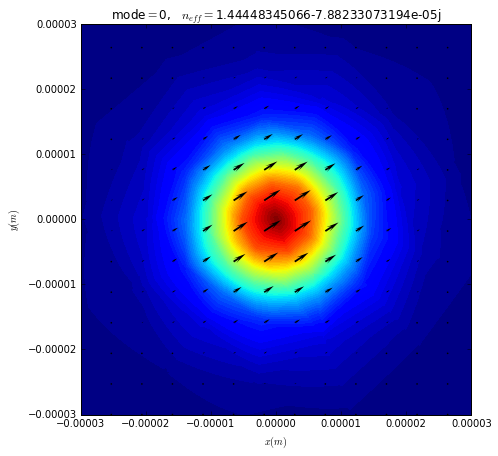

In [35]:
mode1.plot_electric_field(scales = 90000,sp=40)

# Tests

Effective area

In [ ]:
def effective():
    

In [ ]:
if aj:
    print"hello"

def electric_field_full(mode_idx,x,y,k,A,ev,sort_index,free_dofs,combined_space):
    """
    Releases the electric field from the calculated eigenvalus and eigen vectors
    
    Returns::
    E[size,size,2],E_axial(Ez)
    """

    #post-process the coefficients to map back to the full matrix
    coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
    coefficiants_global[free_dofs] = ev[:,sort_index[mode_idx]]
    #Create a Function on the combined space
    mode_re = Function(combined_space)
    mode_im = Function(combined_space)
    #Assign the coefficients of the function to the calculated values
    mode_re.vector().set_local(np.real(coefficiants_global))
    mode_im.vector().set_local(np.imag(coefficiants_global))
    #Split the function into the parts in each of the functions spaces in combined_space
    #This is done using DOLFINs Function.split()
    (TE_re,TM_re) = mode_re.split()
    (TE_im,TM_im) = mode_im.split()

    E = np.zeros([len(x),len(y),2],dtype = np.complex)
    E_axial = np.zeros([len(x),len(y)], dtype= np.complex)
    for i,xx in enumerate(x):
        for j,yy in enumerate(y):
            point = Point(xx,yy)
            E[i,j,:]    =  TE_re(point) + 1j*TE_im(point)
            E_axial[i,j] = TM_re(point) + 1j*TM_im(point)
    return E,E_axial

In [ ]:
x = np.linspace(-r_clad,r_clad,512)
y = np.linspace(-r_clad,r_clad,512)

In [ ]:
delx = x[1] - x[0]
dely = y[1] - y[0]

In [ ]:
En,E_axialn = electric_field_full(propagating_modes[0],x,y,k,A,ev,sort_index,free_dofs,combined_space)
Em,E_axialm = electric_field_full(propagating_modes[1],x,y,k,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
np.max(np.gradient(En[:,:,0],delx,dely)[0] +np.gradient(En[:,:,1],delx,dely)[1] + np.gradient(E_axial))

In [ ]:
np.max(np.gradient(En[:,:,0])[2])

In [ ]:
def overlap_simps(En,E_axialn,Em,E_axialm,x,y):
    integrand1 = np.conjugate(En[:,:,0])*Em[:,:,0] + np.conjugate(En[:,:,1])*Em[:,:,1] + np.conjugate(E_axialn[:,:])*E_axialm[:,:]
    Over = integration2d_simps(x,y,integrand1)
    
    integrand2 = np.abs(En[:,:,0])**2 + np.abs(En[:,:,1])**2 + np.abs(E_axialn[:,:])**2
    under1 = integration2d_simps(x,y,integrand2)
       
    integrand3 = np.abs(Em[:,:,0])**2 + np.abs(Em[:,:,1])**2 + np.abs(E_axialm[:,:])**2
    under2 = integration2d_simps(x,y,integrand3)
    print(np.max(integrand1))#,integrand2,integrand3)
    print(Over,under1,under2)
    return np.abs(Over)**2/(under1*under2)


In [ ]:
integrand1 = np.conjugate(En[:,:,0])*Em[:,:,0] + np.conjugate(En[:,:,1])*Em[:,:,1] + np.conjugate(E_axialn[:,:])*E_axialm[:,:]

In [ ]:
X,Y = np.meshgrid(x,y)
plt.contourf(X,Y,integrand1)
plt.xlim(-r_core,r_core)
plt.ylim(-r_core,r_core)
plt.colorbar()

In [ ]:
overlap_simps(En,E_axialn,Em,E_axialm,x,y)

In [ ]:
from testing.Single_mode_fibre import *


In [ ]:
effective_area_simps(En,E_axialn,x,y)

In [ ]:
effective_area_simps(Em,E_axialm,x,y)

In [ ]:
#Overlaps_simps(3,4,propagating_modes,x,y)
Overlaps_simps(3,4,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
import sympy.vector.coordsysrect

In [ ]:
from sympy.vector import CoordSysCartesian, divergence,curl
R = CoordSysCartesian('R')
v1 = R.x*R.y*R.z * (R.i+R.j+R.k)
divergence(v1, R)
v2 = 2*R.y*R.z*R.j
divergence(v2, R)

In [ ]:
E = R.x*E[:,:,0] +R.y*E[:,:,1]+ R.z*E_axial

In [ ]:
np.diff?

In [ ]:
Overlaps_simps(3,3,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
Overlaps_simps(4,4,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
div(combined_space)

In [ ]:
E,E_axial = electric_field_full(mode_idx,x,y,k,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
def divergence(F):
    """ compute the divergence of n-D scalar field `F` """
    return reduce(np.add,np.gradient(F))

In [ ]:
e_r = n_prof +1j*k_prof

In [ ]:
div = np.gradient(e_r)

In [ ]:
np.shape(e_r)

In [ ]:
np.shape(div)

In [ ]:
beta

In [ ]:
alpha = np.linspace(-5,5,100)
beta = np.copy(alpha)
AR,BR =np.meshgrid(alpha,beta)
alpha,beta = AR,BR
gama = 1/(AR**2 + BR**2)

plt.contourf(AR,BR,gama)

In [ ]:
plt.contourf(AR,BR,divergence(gama))
plt.colorbar()

In [ ]:
np.max(divergence(gama))

In [ ]:
plt.contourf(X,Y,divergence(E[:,:,0]))#+divergence(np.dot(e_r,E[:,:,1])))#+divergence(E_axial))
plt.colorbar()

In [ ]:
sympy.__version__

In [ ]:
import sympy

In [ ]:
coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
coefficiants_global[free_dofs] = ev[:,sort_index[mode_idx]]
mode_re = Function(combined_space)
mode_im = Function(combined_space)
mode_re.vector().set_local(np.real(coefficiants_global))
mode_im.vector().set_local(np.imag(coefficiants_global))
(TE_re,TM_re) = mode_re.split()
(TE_im,TM_im) = mode_im.split()
E = np.zeros([len(x),len(y),2],dtype = np.complex)
E_axial = np.zeros([len(x),len(y)], dtype= np.complex)
for i,xx in enumerate(x):
    for j,yy in enumerate(y):
        point = Point(xx,yy)
        E[i,j,:]    =  TE_re(point) + 1j*TE_im(point)
        E_axial[i,j] = TM_re(point) + 1j*TM_im(point)


In [ ]:
TE_re

In [ ]:
from scipy.misc import derivative


In [ ]:
derivative?

In [ ]:
y = np.empty_like(x)
y[:-1] = (x[1:] - x[:-1]) / delx
y[-1] = -x[-1] / delx

In [ ]:
delx = x[1]- x[0]

In [ ]:
y = np.empty_like(x)

In [ ]:
diver = np.gradient(np.dot(e_r,E[:,:,0]))[1]+np.gradient(np.dot(e_r,E[:,:,1]))[1]+np.gradient(np.dot(e_r,E_axial))[0]

In [ ]:
diver2 = np.gradient(E[:,:,0])[0]+np.gradient(E[:,:,1])[0]+np.gradient(E_axial)[0]

In [ ]:
np.gradient(E[:,:,1])

In [ ]:
np.linalg.norm(diver2)

In [ ]:
plt.contourf(diver2)
plt.colorbar()

In [ ]:
np.dot(e_r,E[:,:,0])

In [ ]:
np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float))

In [ ]:
from netCDF4 import Dataset      
import numpy as np      
import matplotlib.pyplot as plt 

GridSat = Dataset('analysis_20040713_v11l30flk.nc4','r',format='NETCDF4')
missing_data = -9999.0
lat = GridSat.variables['lat']   
lat = lat[:]     
lat[np.where(lat==missing_data)] = np.nan  
lat[np.where(lat > 90.0)] = np.nan     

lon = GridSat.variables['lon']   
lon = lon[:]                
lon[np.where(lon==missing_data)] = np.nan


uwind_data = GridSat.variables['uwnd']  
uwind = GridSat.variables['uwnd'][:]
uwind_sf = uwind_data.scale_factor   
uwind_ao = uwind_data.add_offset
miss_uwind = uwind_data.missing_value

uwind[np.where(uwind==miss_uwind)] = np.nan    


vwind_data = GridSat.variables['vwnd']  
vwind = GridSat.variables['vwnd'][:]
vwind_sf = vwind_data.scale_factor    
vwind_ao = vwind_data.add_offset
miss_vwind = vwind_data.missing_value

vwind[np.where(vwind==miss_vwind)] = np.nan  


uwind = uwind[2,:,:]
vwind = vwind[2,:,:]  

dx = 28400.0 # meters calculated from the 0.25 degree spatial gridding 
dy = 28400.0 # meters calculated from the 0.25 degree spatial gridding 

#dv_dx, dv_dy = np.gradient(vwind, [dx,dy])
#du_dx, du_dy = np.gradient(uwind, [dx,dy])
v_dx, dv_dy = np.gradient(vwind, dx,dy)
du_dx, du_dy = np.gradient(uwind, dx,dy)

In [ ]:
from netCDF4 import Dataset   

In [ ]:
E_large = np.zeros([512,512,3],dtype=np.complex)

In [ ]:
E_large[:,:,0:2] = E
E_large[:,:,-1] =E_axial

In [ ]:
dexdx,dexdy,dexdz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[0][:,:,0], np.gradient(E_large,1,1,1)[0][:,:,1], np.gradient(E_large,1,1,1)[0][:,:,2]

In [ ]:
deydx,deydy,deydz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[1][:,:,0], np.gradient(E_large,1,1,1)[1][:,:,1], np.gradient(E_large,1,1,1)[1][:,:,2]

In [ ]:
dezdx,dezdy,dezdz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[2][:,:,0], np.gradient(E_large,1,1,1)[2][:,:,1], np.gradient(E_large,1,1,1)[2][:,:,2]

In [ ]:
dive =dexdx + deydy +dezdz

In [ ]:
plt.contourf(dive)